# Data Exploration VisDrone

## VisDrone Annotated Data Format

`<bbox_left>, <bbox_top>, <bbox_width>, <bbox_height>, <score>, <object_category>, <truncation>, <occlusion>`

classes:  ignore(0), pedestrian(1), people(2), bicycle(3), car(4), van(5), truck(6), tricycle(7), awning-tricycle(8), bus(9), motor(10), others(11)

In [ ]:
# uncomment below to use ipyml
# %matplotlib widget 

In [1]:
import os
import glob
import math
from typing import List, Tuple, Union, Iterable, Dict
from collections import Counter, defaultdict

import cv2
import imagesize
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker

# import custom packages
import sys
sys.path.append("..") 
from utils.common import get_annot_img_paths, load_visdrone_annots_as_np

ANNOT_EXT = {".txt"}
IMG_EXT = {".jpg", ".png"}
CLASS_ID2LABEL = {0:"ignore", 1:"pedestrian", 2:"people", 3:"bicycle", 4:"car", 5:"van", 
                  6:"truck", 7:"tricycle", 8:"awning-tricycle", 9:"bus", 10:"motor", 11:"others"}

In [2]:
# choose data paths
root_data_dir = "../../data/visdrone_data/OriginalVisDrone/"
train_annots_dir = os.path.join(root_data_dir, "VisDrone2019-DET-train/annotations")
train_images_dir = os.path.join(root_data_dir, "VisDrone2019-DET-train/images")
val_annots_dir = os.path.join(root_data_dir, "VisDrone2019-DET-val/annotations")
val_images_dir = os.path.join(root_data_dir, "VisDrone2019-DET-val/images")
test_annots_dir = os.path.join(root_data_dir, "VisDrone2019-DET-test-dev/annotations")
test_images_dir = os.path.join(root_data_dir, "VisDrone2019-DET-test-dev/images")

# classes to consider
CLASS_IDS_2_CONSIDER = {1, 2, 4, 5, 6, 9}

In [3]:
train_annot_paths, train_image_paths = get_annot_img_paths(train_annots_dir, train_images_dir, ANNOT_EXT, IMG_EXT)
val_annot_paths, val_image_paths = get_annot_img_paths(val_annots_dir, val_images_dir, ANNOT_EXT, IMG_EXT)
test_annot_paths, test_image_paths = get_annot_img_paths(test_annots_dir, test_images_dir, ANNOT_EXT, IMG_EXT)

In [4]:
imgs_loaded = 9
drawn_imgs = []

for i, (ant, img) in enumerate(zip(test_annot_paths, test_image_paths)):
    if i == imgs_loaded:
        break
    image = cv2.imread(img)
    annots = load_visdrone_annots_as_np(ant)
    for annot in annots:
        score, class_id = annot[4], annot[5]
        if class_id not in CLASS_IDS_2_CONSIDER:  # car, van ,truck, bus
            continue
        color = (0, 0, 255) if score == 0 else (0, 255, 0)
        x1, y1, x2, y2 = annot[:4]
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 1)
    drawn_imgs.append(image[:,:,::-1])

## Investigate bbox annotated images 

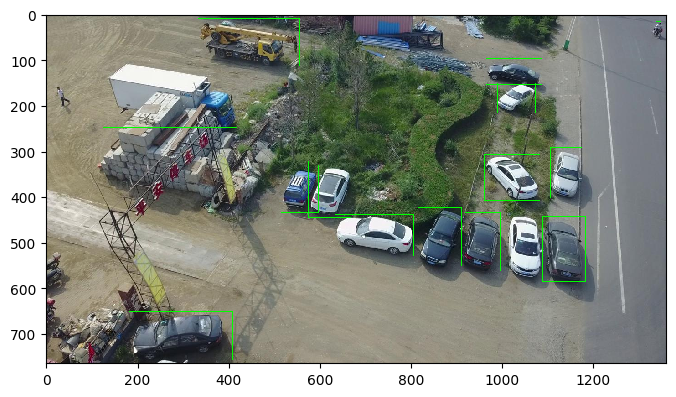

In [5]:
plt.figure(figsize=(8, 8))
plt.imshow(drawn_imgs[2], interpolation='nearest')
plt.show()

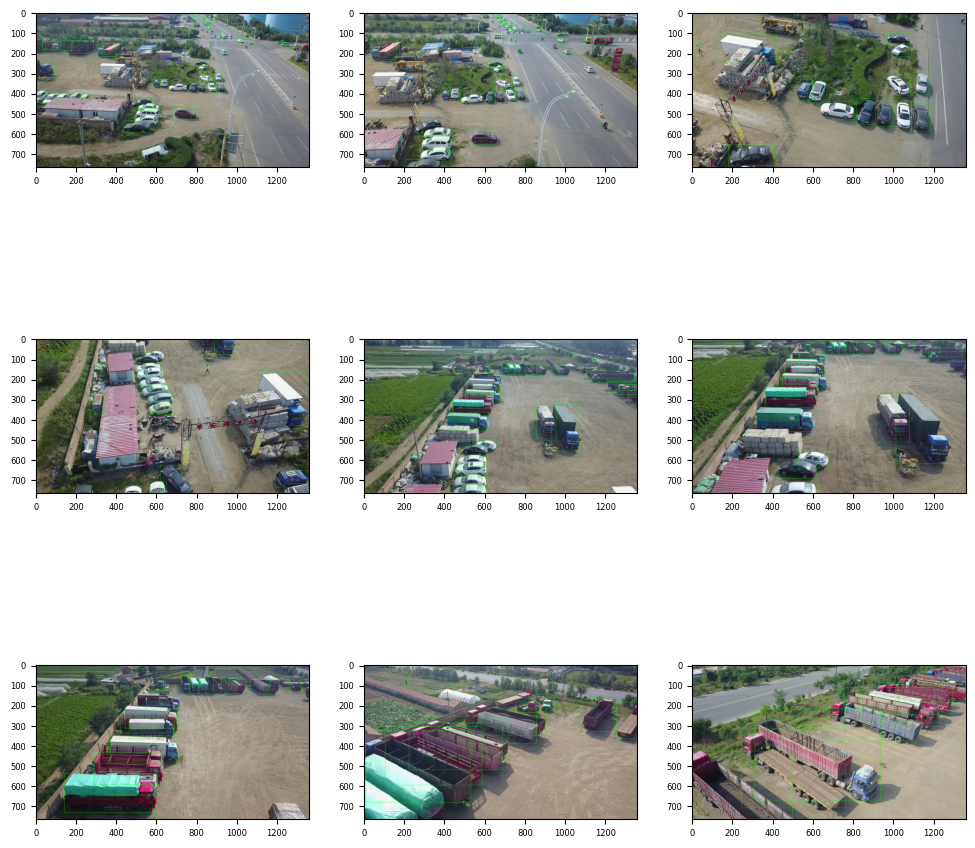

In [6]:
n_row, n_col = 3, 3
_, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
axs = axs.flatten()

for img, ax in zip(drawn_imgs[:imgs_loaded], axs):
    ax.imshow(img)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
plt.show()

## Qualitative Observations from inspecting annotated images

1. Annotated Bbox overlap multiple objects / lots of occulsion in bboxes
2. Bbox scales very from extremely small to decently size (requires statistical histogram binning check)
3. Some images have zero instances of relevant classes
4. Lighting conditions vary (Night, Day, evening) & some images are blurry
5. Viewing angle ranges from elevated sideways (looking down at a slanted angle) to straight down (satellite view but higher resolution)
6. Objects (Cars, trucks) are rotated at all angles (0-360), esp in straight-down views so bbox width/heights have high variation
7. Highly imbalanced in favor of cars & some images have dense number of objects (cars)

## Quantitative Analysis

-  Number of images, bboxes, classes
-  Image Max min avg height
-  Image Max min avg width
-  Histogram binning of image heights & widths across entire dataset
-  Distribution of number of objects across images
-  Class wise distribution of objects across entire dataset
-  Class wise bounding box area as a perc of total area distribution with histogram binning

In [34]:
def generate_data_stats_and_dict(annot_paths: List[str], image_paths: List[str]) -> Dict:
    assert len(annot_paths) == len(image_paths)

    annots = [load_visdrone_annots_as_np(p) for p in annot_paths]
    image_shapes = [imagesize.get(p) for p in image_paths]
    
    image_heights = [h for _, h in image_shapes]
    image_widths = [w for w, _ in image_shapes]
    object_ids_per_img = []
    bbox_area_percs = []
    bbox_classes = []
    bbox_widths = []
    bbox_heights = []
    used_for_eval = 0  # when score = 1
    
    filter_class_arr = np.array(list(CLASS_IDS_2_CONSIDER))
    for i, annot in enumerate(annots):
        # only get classes from CLASS_IDS_2_CONSIDER
        annot = annot[(annot[:,5,None] == filter_class_arr[None,:]).any(axis=1)]
        
        object_ids_per_img.extend(annot.shape[0] * [i])
        used_for_eval += (sum(annot[:, 4]))
        w, h = image_shapes[i]
        image_area = h * w
        bbox = annot[:, :4]
        bwidths, bheights = bbox[:, 2] - bbox[:, 0], bbox[:, 3] - bbox[:, 1]
        bbox_classes.extend(annot[:, 5])
        bbox_widths.extend(bwidths.tolist())
        bbox_heights.extend(bheights.tolist())
        bbox_area = bwidths * bheights
        bbox_area_perc = 100 * bbox_area/image_area
        bbox_area_percs.extend(bbox_area_perc.tolist())
    
    bbox_areas = [h*w for h, w in zip(bbox_heights, bbox_widths)]
    idict = {}
    idict["image_heights"] = image_heights
    idict["image_widths"] = image_widths
    idict["object_ids_per_img"] = object_ids_per_img
    idict["bbox_classes"] = bbox_classes
    idict["bbox_widths"] = bbox_widths
    idict["bbox_heights"] = bbox_heights
    idict["bbox_area_pixels"] = bbox_areas    
    idict["bbox_area_percs"] = bbox_area_percs
    
    print(f"Number of classes: {len(np.unique(bbox_classes)), np.unique(bbox_classes)}")
    print("Used for eval fraction (score=1)", used_for_eval/len(bbox_area_percs))
    print(f"Number of images: {len(image_paths)}")
    print(f" Image height: min {min(image_heights)}, max {max(image_heights)}, avg {sum(image_heights)/len(image_heights):.2f}")
    print(f" Image width: min {min(image_widths)}, max {max(image_widths)}, avg {sum(image_widths)/len(image_widths):.2f}")
    print(f"Number of bboxes: {len(object_ids_per_img)}")
    print(f" BBox height: min {min(bbox_heights)}, max {max(bbox_heights)}, avg {sum(bbox_heights)/len(bbox_heights):.2f}")
    print(f" BBox width: min {min(bbox_widths)}, max {max(bbox_widths)}, avg {sum(bbox_widths)/len(bbox_widths):.2f}")
    print(f" BBox height percentiles (5%, 25%, 50%, 75%, 95%) {np.percentile(bbox_heights, (5, 25, 50, 75, 95))}")
    print(f" BBox width percentiles (5%, 25%, 50%, 75%, 95%) {np.percentile(bbox_widths, (5, 25, 50, 75, 95))}")
    print(f" BBox Area percentiles (33%, 35%, 50%, 66%, 85%) {np.percentile(bbox_areas, (33, 35, 50, 66, 85))}")

    return idict

def remove_outliers_idict_inplace(
    idict: Dict,
    lower_dim_inc_cutoff: float = None,
    lower_area_inc_cutoff: float = None,
) -> None:
    """
    Cutoff is only done by dim or area or by both
    lower_dim_inc_cutoff is in pixels
    lower_area_inc_cutoff is entered as percentage of total image area i.e. 0.1, 1, etc.
    """
    hkey, wkey, clskey  = "bbox_heights", "bbox_widths", "bbox_classes"
    blen = len(idict[hkey])
    print("Before Cutoff")
    print(f"\tTotal number of boxes: {blen}")
    class_count_before = sorted([[CLASS_ID2LABEL[k], v] for k,v in Counter(idict[clskey]).items()])
    print("\tClass Counts:", class_count_before)

    idxs_dim = np.full(blen, True)
    idxs_area = np.full(blen, True)
    if lower_dim_inc_cutoff is not None:
        hw = np.asarray([np.asarray(idict[hkey]), np.asarray(idict[wkey])])
        idxs_dim = np.all(hw >= lower_dim_inc_cutoff, axis=0)
    if lower_area_inc_cutoff is not None:
        idxs_area = np.asarray(idict["bbox_area_percs"]) >= lower_area_inc_cutoff
    idxs = np.logical_and(idxs_dim, idxs_area)

    # do the cutoffs
    idict["object_ids_per_img"] = np.asarray(idict["object_ids_per_img"])[idxs]
    idict[clskey] = np.asarray(idict[clskey])[idxs]
    idict[wkey] = np.asarray(idict[wkey])[idxs]
    idict[hkey] = np.asarray(idict[hkey])[idxs]
    idict["bbox_area_pixels"] = np.asarray(idict["bbox_area_pixels"])[idxs]
    idict["bbox_area_percs"] = np.asarray(idict["bbox_area_percs"])[idxs]
    
    print("After Cutoff")
    print(f"\tTotal number of boxes: {len(idict[hkey])}")
    class_count_after = sorted([[CLASS_ID2LABEL[k], v] for k,v in Counter(idict[clskey]).items()])
    print("\tClass Counts:", class_count_after)
    
    reduction = [[b[0], f"{a[1]/b[1] * 100:.2f}%"] for b, a in zip(class_count_before, class_count_after)]
    print("Remaining class counts after reduction", reduction)
    if lower_dim_inc_cutoff is not None:
        print(f"With a lower width/height dim cutoff value of {lower_dim_inc_cutoff} pixels:")
    if lower_area_inc_cutoff is not None:
        print(f"With a lower bbox area cutoff value of {lower_area_inc_cutoff} %:")
    print(f"\t{100*sum(idxs)/len(idxs):.2f}% of values kept")
    print(f"\tBbox dimensions [min, max]: Width [{min(idict[wkey]), max(idict[wkey])}], Height {min(idict[hkey]), max(idict[hkey])}")

def disp_histograms(
    title: str,
    xlabel: str,
    ylabel: str,
    data_labels: List[str],
    data_list: List[Iterable],
    use_logs: bool = False,
    nbins: int = 50,
    fsize: Tuple[int, int] = (8, 8),
    alpha: float = 0.5,
    xtick_rotation: float = 90,
    xtick_fontsize: int = 8,
    edgecolor: Tuple[int, int, int] = (0, 0, 0),
    DPI: int = 100
):
    assert len(data_labels) == len(data_list)
    min_d, max_d = float('inf'), float('-inf')
    for data in data_list:
        min_d = min(min(data), min_d)
        max_d = max(max(data), max_d)
    # fixed num of bins
    bins = np.linspace(math.ceil(min_d), math.floor(max_d), nbins)

    plt.figure(figsize=fsize, dpi=DPI)
    plt.xlim([min_d-1, max_d+1])
    plt.xticks(np.arange(min_d, max_d+1, 4*(max_d-min_d)//nbins),
               rotation=xtick_rotation, fontsize=xtick_fontsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel + (" (log10)" if use_logs else ""))
    for data, label in zip(data_list, data_labels):
        data = np.log10(np.asarray(data)) if use_logs else data
        plt.hist(data, bins, alpha=alpha, label=label, edgecolor=edgecolor)
    if any(data_labels):
        plt.legend(loc='upper right')
    
    plt.show()

In [35]:
print("\nTrain data statistics:")
idict_train = generate_data_stats_and_dict(train_annot_paths, train_image_paths)

print("\nVal data statistics:")
idict_val = generate_data_stats_and_dict(val_annot_paths, val_image_paths)

print("\nTest data statistics:")
idict_test = generate_data_stats_and_dict(test_annot_paths, test_image_paths)


Train data statistics:
Number of classes: (6, array([1, 2, 4, 5, 6, 9]))
Used for eval fraction (score=1) 1.0
Number of images: 6471
 Image height: min 360, max 1500, avg 1002.40
 Image width: min 480, max 2000, avg 1519.89
Number of bboxes: 295020
 BBox height: min 0, max 790, avg 38.46
 BBox width: min 2, max 983, avg 39.94
 BBox height percentiles (5%, 25%, 50%, 75%, 95%) [  8.  17.  28.  47. 105.]
 BBox width percentiles (5%, 25%, 50%, 75%, 95%) [  6.  13.  26.  51. 120.]
 BBox Area percentiles (33%, 35%, 50%, 66%, 85%) [ 350.  378.  700. 1386. 4160.]

Val data statistics:
Number of classes: (6, array([1, 2, 4, 5, 6, 9]))
Used for eval fraction (score=1) 1.0
Number of images: 548
 Image height: min 540, max 1080, avg 726.24
 Image width: min 960, max 1920, avg 1291.09
Number of bboxes: 31009
 BBox height: min 2, max 616, avg 32.75
 BBox width: min 2, max 580, avg 32.54
 BBox height percentiles (5%, 25%, 50%, 75%, 95%) [ 8. 17. 26. 41. 79.]
 BBox width percentiles (5%, 25%, 50%, 75

In [29]:
train_class_count_before_cutoff = Counter(idict_train["bbox_classes"])

## Distritbution of bbox areas with relation to classes

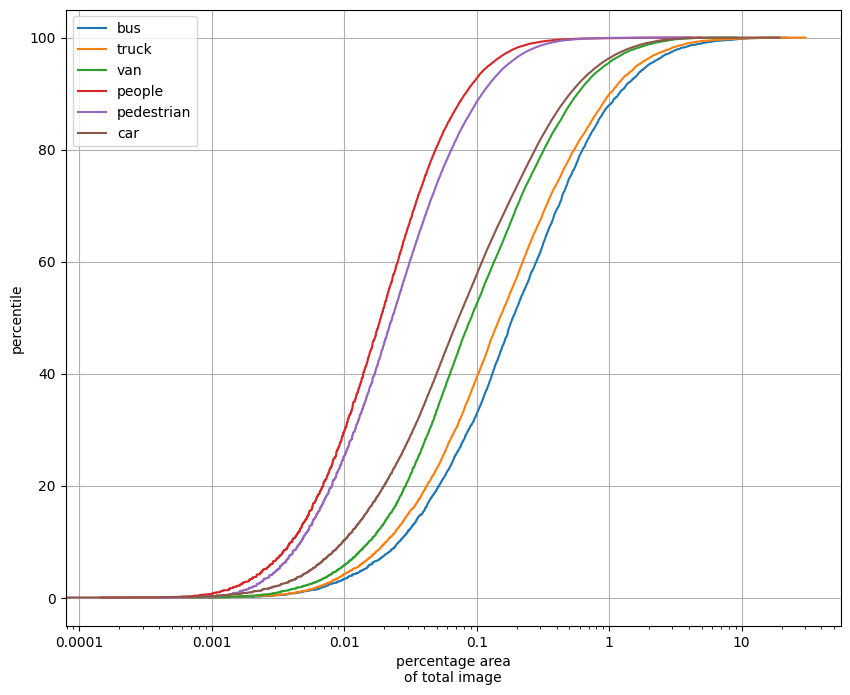

In [30]:
plt.figure(figsize=(10,8))
plt.set_cmap('jet')
p = np.arange(25, 100, 10)

obj_cls_areas = defaultdict(list)
for cls, area in zip(idict_train["bbox_classes"], idict_train["bbox_area_percs"]):
    obj_cls_areas[cls].append(area)

for k in sorted(obj_cls_areas.keys(), key=lambda k: len(obj_cls_areas.get(k))):
    v = obj_cls_areas.get(k)
    v.sort()
    plt.semilogx(v, np.arange(len(v))/len(v)*100, label=CLASS_ID2LABEL.get(k))
    
plt.grid()
plt.legend()
formatter = ticker.FuncFormatter(lambda y, _: '{:g}'.format(y))
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.xlabel('percentage area\nof total image')
plt.ylabel('percentile')
plt.show()

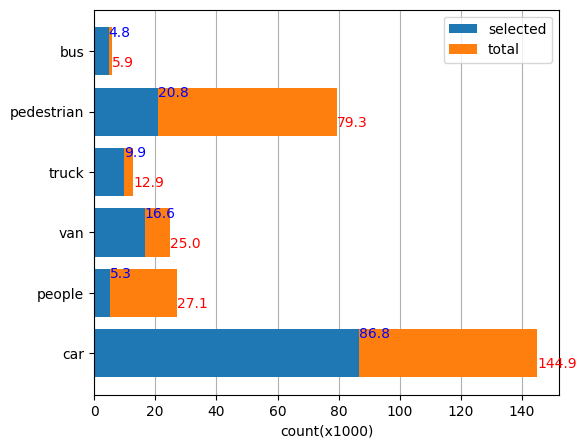

['car: 59.91%', 'people: 19.53%', 'van: 66.53%', 'truck: 76.90%', 'pedestrian: 26.15%', 'bus: 80.64%']
With a percentage cutoff of 0.05%, 48.85% of values kept


In [36]:
cutoff_perc = .05

plt.figure(figsize=(6,5))
class_names = list(map(lambda x: CLASS_ID2LABEL.get(x), obj_cls_areas.keys()))
y_below = list(map(lambda x: len(list(filter(lambda y: y < cutoff_perc, x))), obj_cls_areas.values()))
y_above = list(map(lambda x: len(list(filter(lambda y: y >= cutoff_perc, x))), obj_cls_areas.values()))
plt.barh(class_names, y_above, label='selected')
plt.barh(class_names, y_below, left=y_above, label='total')
for i, (v1, v2) in enumerate(zip(y_above, y_below)):
    plt.gca().text(v1 + 3, i + .25, str(round(v1/1e3, 1)), color='blue')
    plt.gca().text(v1 + v2 + 3, i - .25, str(round((v1+v2)/1e3, 1)), color='red')
plt.xlabel('count(x1000)')
formatter = ticker.FuncFormatter(lambda y, _: f'{int(y/1e3)}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend()
plt.gca().set_axisbelow(True)
plt.grid(axis='x')
plt.show()

selected_perc = [(above / (above + below)) for above, below in zip(y_above, y_below)]
print([f"{cname}: {p * 100:.2f}%" for cname, p in zip(class_names, selected_perc)])
print(f"With a percentage cutoff of {cutoff_perc}%, {100 * sum(y_above) / (sum(y_above) + sum(y_below)):.2f}% of values kept")


In [39]:
# filter bboxes that are very small/outliers but keep large bboxes
lower_dim_cutoff = 20
lower_area_cutoff = 0.05
print("\nFiltering train bboxes based on bbox dims")
remove_outliers_idict_inplace(idict_train, lower_dim_inc_cutoff=lower_dim_cutoff, lower_area_inc_cutoff=lower_area_cutoff)
print("\nFiltering val bboxes based on bbox dims")
remove_outliers_idict_inplace(idict_val, lower_dim_inc_cutoff=lower_dim_cutoff, lower_area_inc_cutoff=lower_area_cutoff)
print("\nFiltering test bboxes based on bbox dims")
remove_outliers_idict_inplace(idict_test, lower_dim_inc_cutoff=lower_dim_cutoff, lower_area_inc_cutoff=lower_area_cutoff)


Filtering train bboxes based on bbox dims
Before Cutoff
	Total number of boxes: 295020
	Class Counts: [['bus', 5926], ['car', 144867], ['pedestrian', 79337], ['people', 27059], ['truck', 12875], ['van', 24956]]
After Cutoff
	Total number of boxes: 133542
	Class Counts: [['bus', 4570], ['car', 82988], ['pedestrian', 16040], ['people', 4412], ['truck', 9594], ['van', 15938]]
Remaining class counts after reduction [['bus', '77.12%'], ['car', '57.29%'], ['pedestrian', '20.22%'], ['people', '16.31%'], ['truck', '74.52%'], ['van', '63.86%']]
With a lower width/height dim cutoff value of 20 pixels:
With a lower bbox area cutoff value of 0.05 %:
	45.27% of values kept
	Bbox dimensions [min, max]: Width [(20, 983)], Height (20, 790)

Filtering val bboxes based on bbox dims
Before Cutoff
	Total number of boxes: 31009
	Class Counts: [['bus', 251], ['car', 14064], ['pedestrian', 8844], ['people', 5125], ['truck', 750], ['van', 1975]]
After Cutoff
	Total number of boxes: 13456
	Class Counts: [['bu

In [38]:
perc_3 = np.percentile(idict_train["bbox_area_pixels"], (33, 50, 85))

print(f' BBox Area percentiles (33%, 50%, 66%) {"total area:",perc_3, "dim:", [round(p**(1/2)) for p in perc_3]}')

 BBox Area percentiles (33%, 50%, 66%) ('total area:', array([ 350.,  700., 4160.]), 'dim:', [19, 26, 64])


### Statistical Graphs

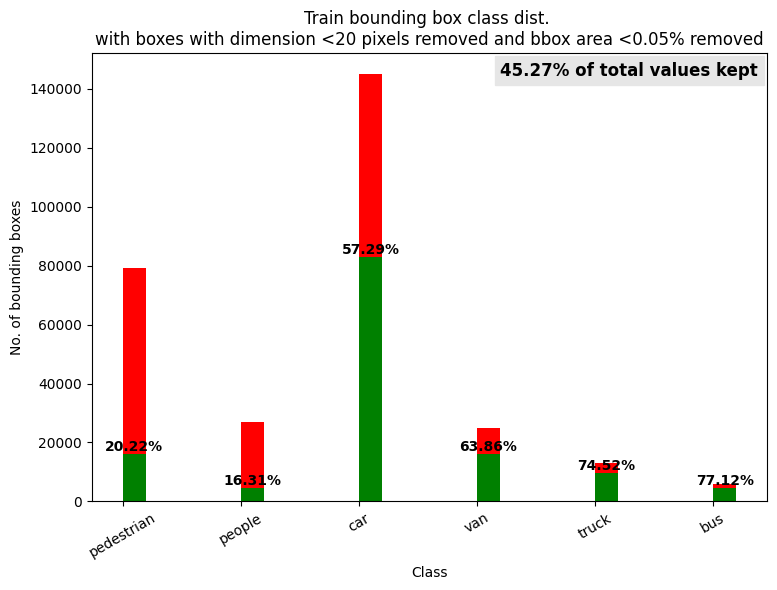

In [45]:
class_bbox_count_list_before_cutoff = sorted([[k, CLASS_ID2LABEL[k], v]
                               for k, v in train_class_count_before_cutoff.items()])
class_name_before_cutoff = [k for _, k, _ in class_bbox_count_list_before_cutoff]
class_counts_before_cutoff = [v for _, _, v in class_bbox_count_list_before_cutoff]

class_bbox_counts_after_cutoff = Counter(idict_train["bbox_classes"])
class_bbox_count_list_after_cutoff = sorted([[k, CLASS_ID2LABEL[k], v]
                               for k, v in class_bbox_counts_after_cutoff.items()])
class_name_after_cutoff = [k for _, k, _ in class_bbox_count_list_after_cutoff]
class_counts_after_cutoff = [v for _, _, v in class_bbox_count_list_after_cutoff]

retained_perc = sum(class_counts_after_cutoff) / sum(class_counts_before_cutoff)
# fig = plt.figure(figsize=(8,6))
fig, ax = plt.subplots(figsize=(8,6))
barb = plt.bar(class_name_before_cutoff, class_counts_before_cutoff, color='red', width=0.2, align='edge')
bara = plt.bar(class_name_after_cutoff, class_counts_after_cutoff, color='green', width=0.2, align='edge')

reduction = [f"{a/b * 100:.2f}%" for i, (b, a) in enumerate(zip(class_counts_before_cutoff, class_counts_after_cutoff))]
# Add percs above the two bar graphs
for i, rect in enumerate(bara):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{reduction[i]}', ha='center', va='bottom', fontsize="medium", fontweight ="bold")

plt.xticks(rotation=30)
plt.xlabel("Class")
plt.ylabel("No. of bounding boxes")
plt.title(f"Train bounding box class dist. \nwith boxes with dimension <{lower_dim_cutoff} pixels removed and bbox area <{lower_area_cutoff}% removed")
plt.text(0.605, 0.95, f"{retained_perc*100:.2f}% of total values kept", transform=ax.transAxes, fontweight="bold", fontsize="large", backgroundcolor=(.9,.9,.9))
fig.tight_layout()
plt.show()

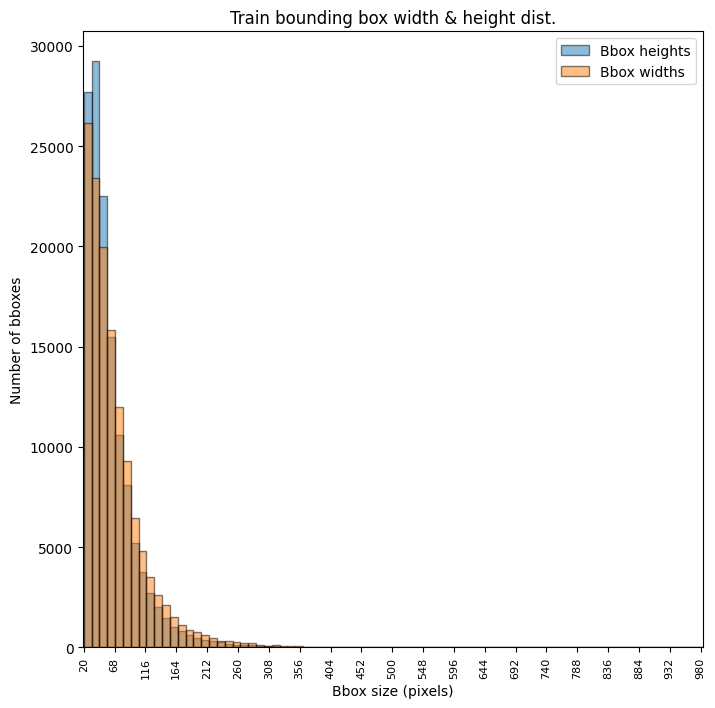

In [41]:
disp_histograms(title = "Train bounding box width & height dist.", 
                xlabel = "Bbox size (pixels)", 
                ylabel = "Number of bboxes",
                data_labels = ["Bbox heights", "Bbox widths"],
                data_list =[idict_train["bbox_heights"], idict_train["bbox_widths"]],
                nbins=80)

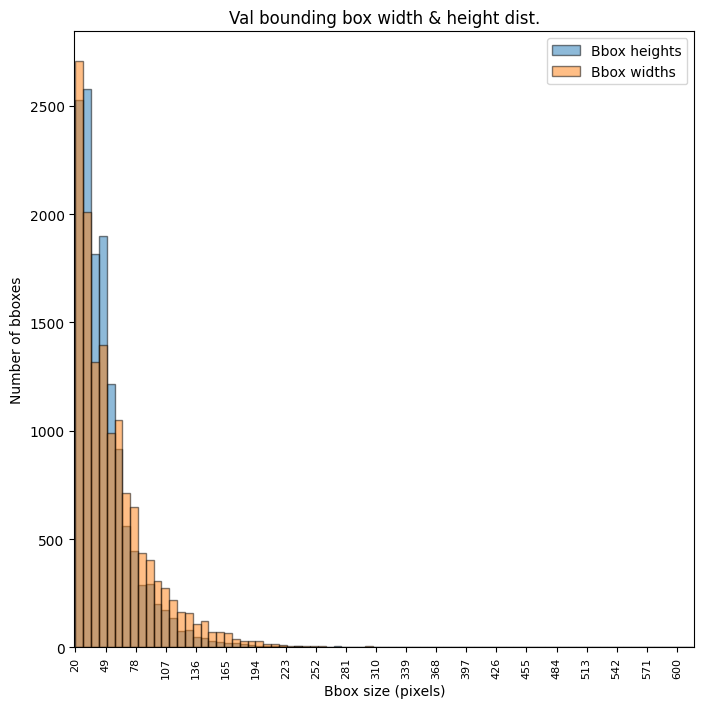

In [42]:
disp_histograms(title = "Val bounding box width & height dist.", 
                xlabel = "Bbox size (pixels)", 
                ylabel = "Number of bboxes",
                data_labels = ["Bbox heights", "Bbox widths"],
                data_list =[idict_val["bbox_heights"], idict_val["bbox_widths"]],
                nbins=80)

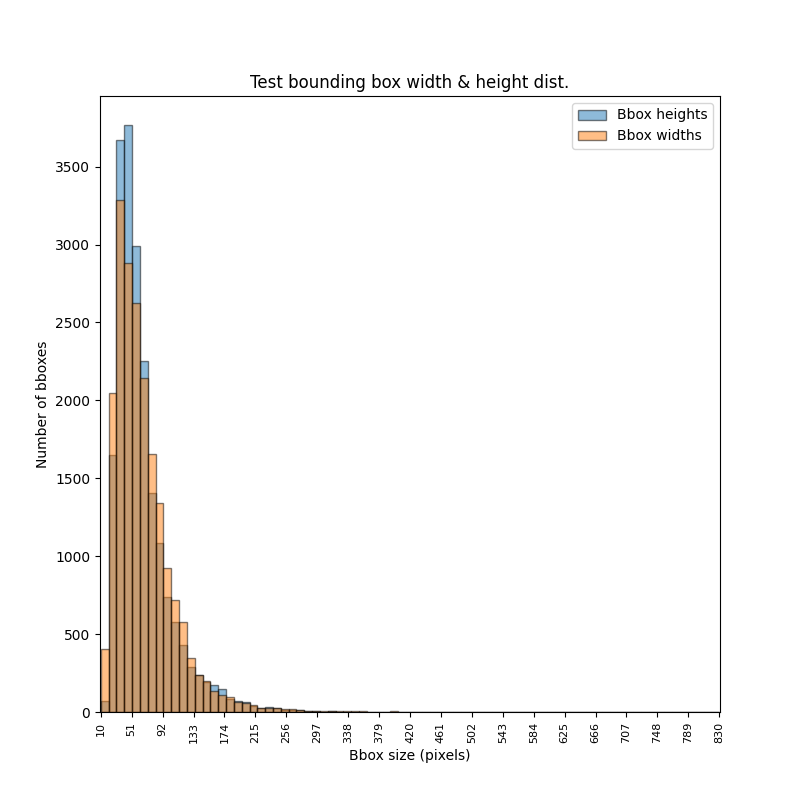

In [76]:
disp_histograms(title = "Test bounding box width & height dist.", 
                xlabel = "Bbox size (pixels)", 
                ylabel = "Number of bboxes",
                data_labels = ["Bbox heights", "Bbox widths"],
                data_list =[idict_test["bbox_heights"], idict_test["bbox_widths"]],
                nbins=80)

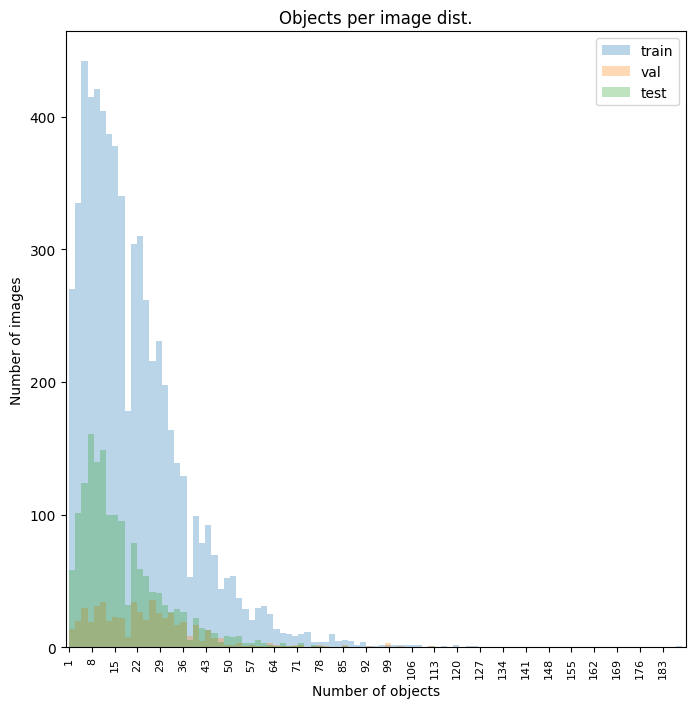

In [43]:
disp_histograms(title ="Objects per image dist.", 
                xlabel = "Number of objects", 
                ylabel = "Number of images",
                data_labels = ["train", "val", "test"],
                data_list =[list(Counter(idict_train["object_ids_per_img"]).values()), 
                            list(Counter(idict_val["object_ids_per_img"]).values()), 
                            list(Counter(idict_test["object_ids_per_img"]).values())],
                nbins=100,
                alpha=0.3,
                edgecolor=None)

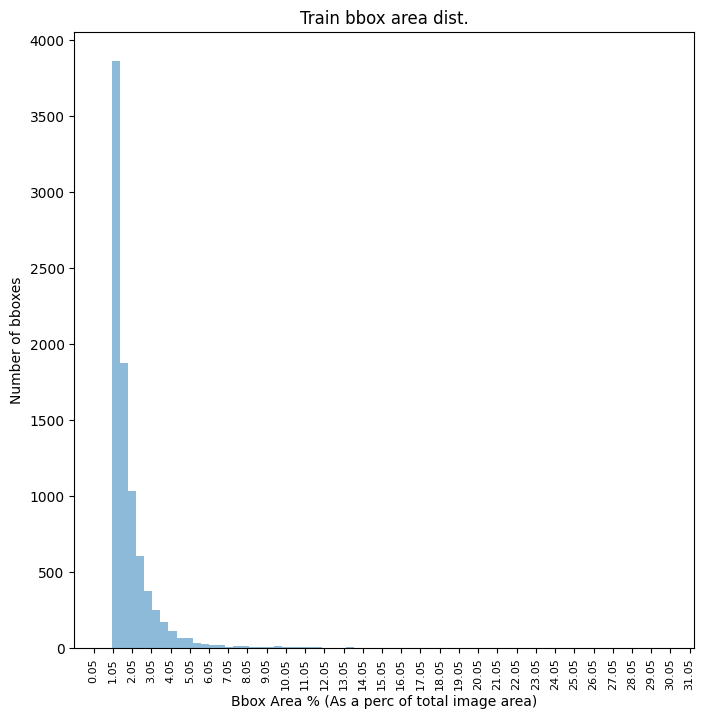

In [44]:
disp_histograms(title ="Train bbox area dist.", 
                xlabel = "Bbox Area % (As a perc of total image area)", 
                ylabel = "Number of bboxes",
                data_labels = [None],
                data_list =[idict_train["bbox_area_percs"]],
                nbins=70,
                use_logs=False,
                edgecolor=None)

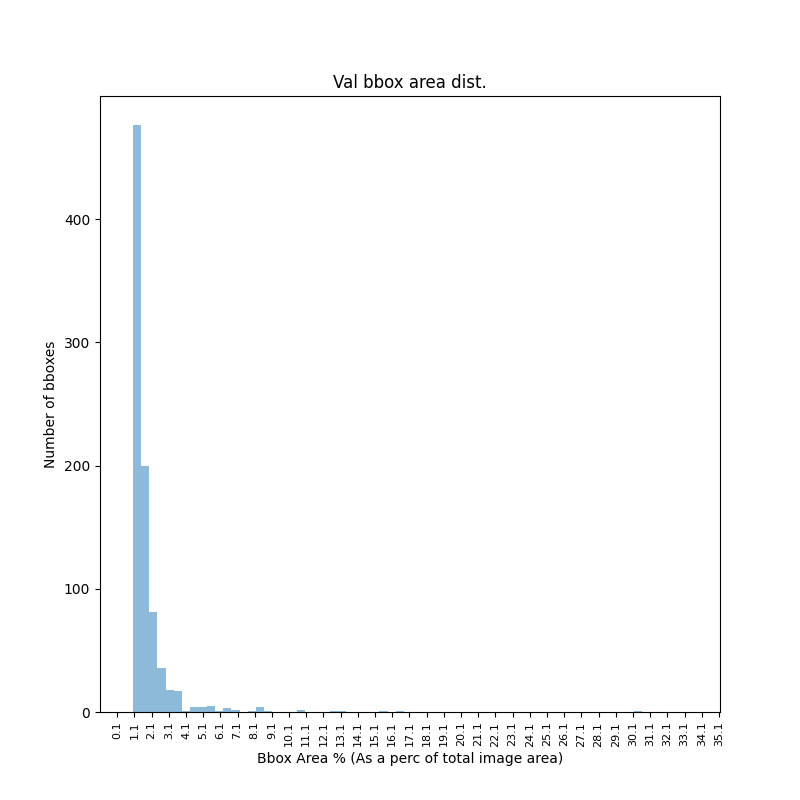

In [79]:
disp_histograms(title ="Val bbox area dist.", 
                xlabel = "Bbox Area % (As a perc of total image area)", 
                ylabel = "Number of bboxes",
                data_labels = [None],
                data_list =[idict_val["bbox_area_percs"]],
                nbins=70,
                use_logs=False,
                edgecolor=None)

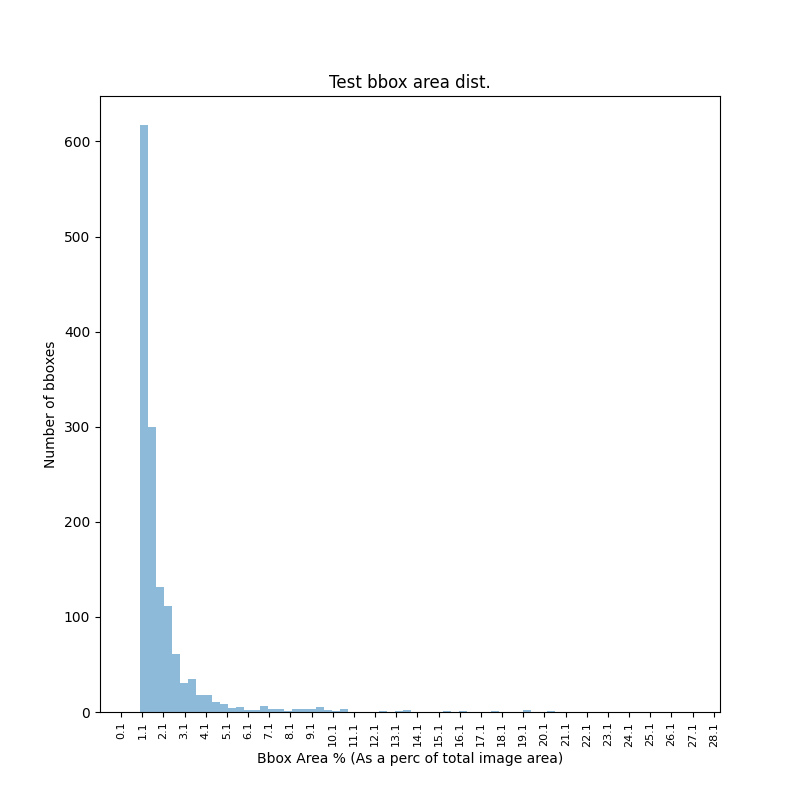

In [80]:
disp_histograms(title ="Test bbox area dist.", 
                xlabel = "Bbox Area % (As a perc of total image area)", 
                ylabel = "Number of bboxes",
                data_labels = [None],
                data_list =[idict_test["bbox_area_percs"]],
                nbins=70,
                use_logs=False,
                edgecolor=None)